In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm
import random, sys, os

In [3]:
import sparse_linear_lib as sll

In [19]:
device = torch.device("cuda:0")

## Pair Linear approximation

In [392]:
N = 1024
seeds = [147, 258, 369, 321, 654, 987, 741, 852, 963, 159]
SEED = seeds[0]

In [393]:
torch.manual_seed(SEED)
## A is a target matrix
# A = torch.randn(N, N).to(device)
A = torch.rand(N, N).to(device)*2-1 

In [394]:
X = torch.eye(N).to(device)

In [395]:
model = sll.PairLinear_MixerBlock(N, N).to(device)

In [396]:
model(X)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [397]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

mse = nn.MSELoss()
def mae(A, B):
    return torch.abs(A-B).mean()

criterion = mse
# criterion = mae

In [398]:
### forward propagation
for i in range(20000):
    out = model.forward(X)
    loss = criterion(out, A)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%1000 == 0:
        print(f"The MSE loss is : {float(mse(out,A))}")
#         print(f"The MAE loss is : {float(mae(out,A))}")
#         diff = (out.data-A).abs()        
#         plt.hist(diff.cpu().numpy().reshape(-1), bins=100)
#         plt.show()

The MSE loss is : 0.3339892029762268
The MSE loss is : 0.3258676826953888
The MSE loss is : 0.32435426115989685
The MSE loss is : 0.32379475235939026
The MSE loss is : 0.32352203130722046
The MSE loss is : 0.3233267366886139
The MSE loss is : 0.3232240378856659
The MSE loss is : 0.32311922311782837
The MSE loss is : 0.3230302929878235
The MSE loss is : 0.3229886293411255
The MSE loss is : 0.32296428084373474
The MSE loss is : 0.32294341921806335
The MSE loss is : 0.3229249119758606
The MSE loss is : 0.32291942834854126
The MSE loss is : 0.32291924953460693
The MSE loss is : 0.32291921973228455
The MSE loss is : 0.32291924953460693
The MSE loss is : 0.32291924953460693
The MSE loss is : 0.32291921973228455
The MSE loss is : 0.32291921973228455


In [399]:
torch.det(A)

tensor(-inf, device='cuda:0')

In [400]:
torch.det(out.data)

tensor(-0., device='cuda:0')

In [401]:
diff = (out.data-A).abs()

In [402]:
diff.min(), diff.max()

(tensor(2.8480e-06, device='cuda:0'), tensor(1.4972, device='cuda:0'))

In [403]:
diff.mean(), diff.std()

(tensor(0.4896, device='cuda:0'), tensor(0.2885, device='cuda:0'))

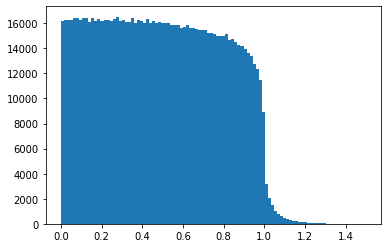

In [404]:
plt.hist(diff.cpu().numpy().reshape(-1), bins=100)
plt.show()

## Approximation using SVD / Eigen

In [405]:
U, S, V = torch.svd(A)

In [406]:
_m = int(np.ceil(np.sqrt(N)))
# _m = N // 2
_m

32

In [407]:
n_params = sum(p.numel() for p in model.parameters())
_m = int(np.ceil(n_params/(U.shape[0]*2)))
_m

10

In [408]:
_S = S.clone()
_S[_m:] *= 0
_S

tensor([36.7376, 36.5132, 36.2850,  ...,  0.0000,  0.0000,  0.0000],
       device='cuda:0')

In [409]:
out = torch.mm(torch.mm(U, torch.diag(_S)), V.t())
mse(out, A)

tensor(0.3207, device='cuda:0')

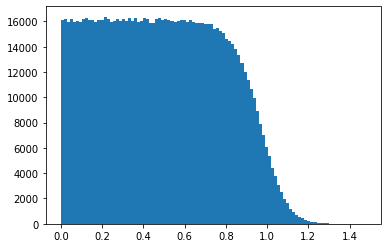

In [410]:
diff = (out.data-A).abs()        
plt.hist(diff.cpu().numpy().reshape(-1), bins=100)
plt.show()

In [411]:
diff.min(), diff.max()

(tensor(2.1327e-07, device='cuda:0'), tensor(1.4762, device='cuda:0'))

In [412]:
diff.mean(), diff.std()

(tensor(0.4874, device='cuda:0'), tensor(0.2884, device='cuda:0'))

In [413]:
U.shape[0]*_m*2

20480

In [414]:
torch.numel(A)

1048576

In [415]:
## for 2x2 linear
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  20480


## Approximating Low Rank

In [419]:
model = nn.Sequential(nn.Linear(N, _m, bias=False), nn.Linear(_m, N, bias=False)).to(device)
# model = nn.Linear(N, N, bias=False).to(device) ## it can easily approximate to ~ 0 error

In [420]:
model(X)

tensor([[ 0.0060, -0.0139,  0.0148,  ...,  0.0164, -0.0290, -0.0076],
        [ 0.0224, -0.0002,  0.0012,  ...,  0.0221, -0.0045, -0.0245],
        [-0.0305, -0.0125, -0.0123,  ..., -0.0017,  0.0268,  0.0146],
        ...,
        [-0.0305,  0.0119,  0.0181,  ..., -0.0130,  0.0020, -0.0273],
        [-0.0144, -0.0310,  0.0182,  ...,  0.0251,  0.0013,  0.0205],
        [-0.0222,  0.0281, -0.0102,  ..., -0.0309, -0.0098,  0.0156]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [421]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1048576


In [422]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [423]:
### forward propagation
for i in range(20000):
    out = model.forward(X)
    loss = criterion(out, A)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%1000 == 0:
        print(f"The MSE loss is : {float(mse(out,A))}")
#         print(f"The MAE loss is : {float(mae(out,A))}")
#         diff = (out.data-A).abs()        
#         plt.hist(diff.cpu().numpy().reshape(-1), bins=100)
#         plt.show()

The MSE loss is : 0.33337754011154175
The MSE loss is : 0.009387862868607044
The MSE loss is : 3.0878494726493955e-05
The MSE loss is : 2.4046762359120066e-09
The MSE loss is : 2.4860326471032312e-12
The MSE loss is : 9.726195543402483e-13
The MSE loss is : 3.9987571630664687e-13
The MSE loss is : 1.7556336701259057e-13
The MSE loss is : 8.433788471198453e-14
The MSE loss is : 4.5332203838172394e-14
The MSE loss is : 2.7468353519478558e-14
The MSE loss is : 1.9301187303153236e-14
The MSE loss is : 1.5746212046383566e-14
The MSE loss is : 1.2125027612258817e-14
The MSE loss is : 8.11351345538034e-15
The MSE loss is : 8.11351345538034e-15
The MSE loss is : 8.11351345538034e-15
The MSE loss is : 8.11351345538034e-15
The MSE loss is : 8.11351345538034e-15
The MSE loss is : 8.11351345538034e-15


In [386]:
torch.det(A)

tensor(4.5065e+28, device='cuda:0')

In [387]:
torch.det(out.data)

tensor(0., device='cuda:0')

In [388]:
diff = (out.data-A).abs()

In [389]:
diff.min(), diff.max()

(tensor(0.0005, device='cuda:0'), tensor(1.3825, device='cuda:0'))

In [390]:
diff.mean(), diff.std()

(tensor(0.4049, device='cuda:0'), tensor(0.2730, device='cuda:0'))

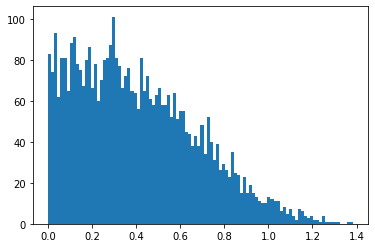

In [391]:
plt.hist(diff.cpu().numpy().reshape(-1), bins=100)
plt.show()

### Testing Factorized Addition of 2x2 Factorization

In [437]:
class Add_PairLinears(nn.Module):
    
    def __init__(self, input_dim, num_adds):
        super().__init__()
        self.pair_mixers = []
        self.perm_indices = []
        for i in range(num_adds):
            m = sll.PairLinear_MixerBlock(input_dim, input_dim)
            self.pair_mixers.append(m)
            if i > 0:
                rm = torch.randperm(input_dim)
                self.perm_indices.append(rm)
                
        self.pair_mixers = nn.ModuleList(self.pair_mixers)
        
    def forward(self, x):
        y = torch.zeros_like(x)
        for i, m in enumerate(self.pair_mixers):
            if i > 0:
                _x = x[:, self.perm_indices[i-1]]
            else:
                _x = x
                
            y += m(_x)
        return y

In [450]:
model = Add_PairLinears(N, 4).to(device)

In [451]:
model

Add_PairLinears(
  (pair_mixers): ModuleList(
    (0): PairLinear_MixerBlock(
      (selector): Identity()
      (pairwise_mixing): ModuleList(
        (0): PairLinear: [1024 -> 1024]
        (1): PairLinear: [1024 -> 1024]
        (2): PairLinear: [1024 -> 1024]
        (3): PairLinear: [1024 -> 1024]
        (4): PairLinear: [1024 -> 1024]
        (5): PairLinear: [1024 -> 1024]
        (6): PairLinear: [1024 -> 1024]
        (7): PairLinear: [1024 -> 1024]
        (8): PairLinear: [1024 -> 1024]
        (9): PairLinear: [1024 -> 1024]
      )
      (reducer): Identity()
    )
    (1): PairLinear_MixerBlock(
      (selector): Identity()
      (pairwise_mixing): ModuleList(
        (0): PairLinear: [1024 -> 1024]
        (1): PairLinear: [1024 -> 1024]
        (2): PairLinear: [1024 -> 1024]
        (3): PairLinear: [1024 -> 1024]
        (4): PairLinear: [1024 -> 1024]
        (5): PairLinear: [1024 -> 1024]
        (6): PairLinear: [1024 -> 1024]
        (7): PairLinear: [1024 -> 10

In [452]:
model(X)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [453]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [454]:
### forward propagation
for i in range(20000):
    out = model.forward(X)
    loss = criterion(out, A)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%1000 == 0:
        print(f"The MSE loss is : {float(mse(out,A))}")
#         print(f"The MAE loss is : {float(mae(out,A))}")
#         diff = (out.data-A).abs()        
#         plt.hist(diff.cpu().numpy().reshape(-1), bins=100)
#         plt.show()

The MSE loss is : 0.3367670178413391
The MSE loss is : 0.2947320342063904
The MSE loss is : 0.29385197162628174
The MSE loss is : 0.2934921085834503
The MSE loss is : 0.29342126846313477
The MSE loss is : 0.29336464405059814
The MSE loss is : 0.2933483421802521
The MSE loss is : 0.2933477759361267
The MSE loss is : 0.29334765672683716
The MSE loss is : 0.29334771633148193
The MSE loss is : 0.2933478355407715
The MSE loss is : 0.2933480143547058
The MSE loss is : 0.29334762692451477
The MSE loss is : 0.29334771633148193
The MSE loss is : 0.2933477759361267
The MSE loss is : 0.29334786534309387
The MSE loss is : 0.29334756731987
The MSE loss is : 0.29334765672683716
The MSE loss is : 0.29334843158721924
The MSE loss is : 0.2933475971221924


In [455]:
'''
The MSE loss is : 0.32291921973228455
'''

'\nThe MSE loss is : 0.3339892029762268\nThe MSE loss is : 0.3258676826953888\nThe MSE loss is : 0.32435426115989685\nThe MSE loss is : 0.32379475235939026\nThe MSE loss is : 0.32352203130722046\nThe MSE loss is : 0.3233267366886139\nThe MSE loss is : 0.3232240378856659\nThe MSE loss is : 0.32311922311782837\nThe MSE loss is : 0.3230302929878235\nThe MSE loss is : 0.3229886293411255\nThe MSE loss is : 0.32296428084373474\nThe MSE loss is : 0.32294341921806335\nThe MSE loss is : 0.3229249119758606\nThe MSE loss is : 0.32291942834854126\nThe MSE loss is : 0.32291924953460693\nThe MSE loss is : 0.32291921973228455\nThe MSE loss is : 0.32291924953460693\nThe MSE loss is : 0.32291924953460693\nThe MSE loss is : 0.32291921973228455\nThe MSE loss is : 0.32291921973228455\n'

In [456]:
torch.det(A)

tensor(-inf, device='cuda:0')

In [457]:
torch.det(out.data)

tensor(-inf, device='cuda:0')

In [458]:
diff = (out.data-A).abs()

In [459]:
diff.min(), diff.max()

(tensor(7.3761e-07, device='cuda:0'), tensor(1.6188, device='cuda:0'))

In [460]:
diff.mean(), diff.std()

(tensor(0.4601, device='cuda:0'), tensor(0.2858, device='cuda:0'))

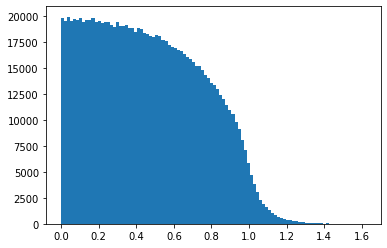

In [461]:
plt.hist(diff.cpu().numpy().reshape(-1), bins=100)
plt.show()

### Testing Factorized Stacking of 2x2 Factorization

In [462]:
class Stack_PairLinears(nn.Module):
    
    def __init__(self, input_dim, num_adds):
        super().__init__()
        self.pair_mixers = []
        self.perm_indices = []
        for i in range(num_adds):
            m = sll.PairLinear_MixerBlock(input_dim, input_dim)
            self.pair_mixers.append(m)
            if i > 0:
                rm = torch.randperm(input_dim)
                self.perm_indices.append(rm)
                
        self.pair_mixers = nn.ModuleList(self.pair_mixers)
        
    def forward(self, x):
        for i, m in enumerate(self.pair_mixers):
            if i == 0:
                x = m(x)
            else:
                x = m(x[:, self.perm_indices[i-1]])
        return x

In [463]:
model = Add_PairLinears(N, 4).to(device)

In [464]:
model

Add_PairLinears(
  (pair_mixers): ModuleList(
    (0): PairLinear_MixerBlock(
      (selector): Identity()
      (pairwise_mixing): ModuleList(
        (0): PairLinear: [1024 -> 1024]
        (1): PairLinear: [1024 -> 1024]
        (2): PairLinear: [1024 -> 1024]
        (3): PairLinear: [1024 -> 1024]
        (4): PairLinear: [1024 -> 1024]
        (5): PairLinear: [1024 -> 1024]
        (6): PairLinear: [1024 -> 1024]
        (7): PairLinear: [1024 -> 1024]
        (8): PairLinear: [1024 -> 1024]
        (9): PairLinear: [1024 -> 1024]
      )
      (reducer): Identity()
    )
    (1): PairLinear_MixerBlock(
      (selector): Identity()
      (pairwise_mixing): ModuleList(
        (0): PairLinear: [1024 -> 1024]
        (1): PairLinear: [1024 -> 1024]
        (2): PairLinear: [1024 -> 1024]
        (3): PairLinear: [1024 -> 1024]
        (4): PairLinear: [1024 -> 1024]
        (5): PairLinear: [1024 -> 1024]
        (6): PairLinear: [1024 -> 1024]
        (7): PairLinear: [1024 -> 10

In [465]:
model(X)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [466]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [467]:
### forward propagation
for i in range(20000):
    out = model.forward(X)
    loss = criterion(out, A)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%1000 == 0:
        print(f"The MSE loss is : {float(mse(out,A))}")
#         print(f"The MAE loss is : {float(mae(out,A))}")
#         diff = (out.data-A).abs()        
#         plt.hist(diff.cpu().numpy().reshape(-1), bins=100)
#         plt.show()

The MSE loss is : 0.33698195219039917
The MSE loss is : 0.294692724943161
The MSE loss is : 0.29375672340393066
The MSE loss is : 0.2934374511241913
The MSE loss is : 0.2932818830013275
The MSE loss is : 0.2932470738887787
The MSE loss is : 0.2932029664516449
The MSE loss is : 0.29320037364959717
The MSE loss is : 0.2932015061378479
The MSE loss is : 0.29320043325424194
The MSE loss is : 0.29320043325424194
The MSE loss is : 0.2932007908821106
The MSE loss is : 0.2932009696960449
The MSE loss is : 0.29320037364959717
The MSE loss is : 0.29320040345191956
The MSE loss is : 0.29320043325424194
The MSE loss is : 0.2932018041610718
The MSE loss is : 0.2932004928588867
The MSE loss is : 0.29320037364959717
The MSE loss is : 0.293201208114624


In [455]:
'''
The MSE loss is : 0.32291921973228455 --> For plain 2x2
The MSE loss is : 0.2933475971221924 --> For 4 parallel added 2x2
'''

'\nThe MSE loss is : 0.3339892029762268\nThe MSE loss is : 0.3258676826953888\nThe MSE loss is : 0.32435426115989685\nThe MSE loss is : 0.32379475235939026\nThe MSE loss is : 0.32352203130722046\nThe MSE loss is : 0.3233267366886139\nThe MSE loss is : 0.3232240378856659\nThe MSE loss is : 0.32311922311782837\nThe MSE loss is : 0.3230302929878235\nThe MSE loss is : 0.3229886293411255\nThe MSE loss is : 0.32296428084373474\nThe MSE loss is : 0.32294341921806335\nThe MSE loss is : 0.3229249119758606\nThe MSE loss is : 0.32291942834854126\nThe MSE loss is : 0.32291924953460693\nThe MSE loss is : 0.32291921973228455\nThe MSE loss is : 0.32291924953460693\nThe MSE loss is : 0.32291924953460693\nThe MSE loss is : 0.32291921973228455\nThe MSE loss is : 0.32291921973228455\n'

In [468]:
torch.det(A)

tensor(-inf, device='cuda:0')

In [469]:
torch.det(out.data)

tensor(inf, device='cuda:0')

In [470]:
diff = (out.data-A).abs()

In [471]:
diff.min(), diff.max()

(tensor(2.0862e-07, device='cuda:0'), tensor(1.6561, device='cuda:0'))

In [472]:
diff.mean(), diff.std()

(tensor(0.4598, device='cuda:0'), tensor(0.2860, device='cuda:0'))

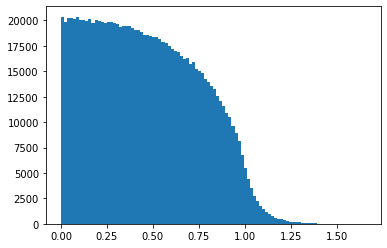

In [473]:
plt.hist(diff.cpu().numpy().reshape(-1), bins=100)
plt.show()

### Testing Factorized Multiplication of 2x2 Factorization

It does not seem to work.. removing the codes

In [1]:
'''
The MSE loss is : 0.32291921973228455 --> For plain 2x2
The MSE loss is : 0.2933475971221924 --> For 4 parallel added 2x2
The MSE loss is : 0.293201208114624 --> For 4 serial composed 2x2
  --> For 4 parallel multiplied 2x2
'''
print()